# Initiating the connection with pyspark

In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'C:\\Spark\\spark-3.1.1-bin-hadoop2.7'

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import*

In [3]:
from pyspark.sql import SparkSession
conf=pyspark.SparkConf().setAppName('SparkApp').setMaster('local')
sc=pyspark.SparkContext(conf=conf)
spark=SparkSession(sc)

In [4]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [5]:
spark = SparkSession.Builder().getOrCreate()

# Reading the dataset and preprocessing it

In [6]:
flightSchema = StructType([
  StructField("DayofMonth", IntegerType(), False),
  StructField("DayOfWeek", IntegerType(), False),
  StructField("Carrier", StringType(), False),
  StructField("OriginAirportID", IntegerType(), False),
  StructField("DestAirportID", IntegerType(), False),
  StructField("DepDelay", IntegerType(), False),
  StructField("ArrDelay", IntegerType(), False),
])

flights = spark.read.csv('dataset/raw-flight-data.csv', 
                         schema=flightSchema, header=True)
flights.show(10)

+----------+---------+-------+---------------+-------------+--------+--------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|
+----------+---------+-------+---------------+-------------+--------+--------+
|        19|        5|     DL|          11433|        13303|      -3|       1|
|        19|        5|     DL|          14869|        12478|       0|      -8|
|        19|        5|     DL|          14057|        14869|      -4|     -15|
|        19|        5|     DL|          15016|        11433|      28|      24|
|        19|        5|     DL|          11193|        12892|      -6|     -11|
|        19|        5|     DL|          10397|        15016|      -1|     -19|
|        19|        5|     DL|          15016|        10397|       0|      -1|
|        19|        5|     DL|          10397|        14869|      15|      24|
|        19|        5|     DL|          10397|        10423|      33|      34|
|        19|        5|     DL|          11278|      

In [7]:
airportSchema = StructType([
  StructField("airport_id", IntegerType(), False),
  StructField("city", StringType(), False),
  StructField("state", StringType(), False),
  StructField("name", StringType(), False),
])

airports = spark.read.csv('dataset/airports.csv', header=True, 
                          schema=airportSchema)
airports.show(10)

+----------+-----------+-----+--------------------+
|airport_id|       city|state|                name|
+----------+-----------+-----+--------------------+
|     10165|Adak Island|   AK|                Adak|
|     10299|  Anchorage|   AK|Ted Stevens Ancho...|
|     10304|      Aniak|   AK|       Aniak Airport|
|     10754|     Barrow|   AK|Wiley Post/Will R...|
|     10551|     Bethel|   AK|      Bethel Airport|
|     10926|    Cordova|   AK|Merle K Mudhole S...|
|     14709|  Deadhorse|   AK|   Deadhorse Airport|
|     11336| Dillingham|   AK|  Dillingham Airport|
|     11630|  Fairbanks|   AK|Fairbanks Interna...|
|     11997|   Gustavus|   AK|    Gustavus Airport|
+----------+-----------+-----+--------------------+
only showing top 10 rows



+ Merge two dataFrame (flight and airports), and show how many flights from each City

In [8]:
flightsByOrigin = flights.join(airports,
                               flights.OriginAirportID == 
                               airports.airport_id).groupBy("city").count()
flightsByOrigin.show(3)

+--------------+-----+
|          city|count|
+--------------+-----+
|       Phoenix|90281|
|         Omaha|13537|
|Raleigh/Durham|28436|
+--------------+-----+
only showing top 3 rows



+ **Removing Duplicate data**

In [9]:
#count the number of original data rows
n1 = flights.count()
print("number of original data rows: ", n1)
#count the number of data rows after deleting duplicated data
n2 = flights.dropDuplicates().count()
print("number of data rows after deleting duplicated data: ", n2)
n3 = n1 - n2
print("number of duplicated data: ", n3)

number of original data rows:  2719418
number of data rows after deleting duplicated data:  2696983
number of duplicated data:  22435


In [10]:
flights =  flights.dropDuplicates()
n4 = flights.count()
print(n4)

2696983


+ Duplicate entries successively removed

+ **Handline missing data**

In [11]:
flights.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in flights.columns]).show()

+----------+---------+-------+---------------+-------------+--------+--------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|
+----------+---------+-------+---------------+-------------+--------+--------+
|         0|        0|      0|              0|            0|   22209|   23798|
+----------+---------+-------+---------------+-------------+--------+--------+



In [12]:
flightsNoMissingValue = flights.dropna(
    how="any", subset=["ArrDelay", "DepDelay"])# use how="all" for all column missing data
numberOfMissingValueAny = n1 - flightsNoMissingValue.count()

print("number of missing value rows: ", numberOfMissingValueAny)

number of missing value rows:  46233


In [13]:
#take mean value
meanArrDelay = flights.groupBy().avg("ArrDelay").take(1)[0][0]
print("mean ArrDelay: ", meanArrDelay)
meanDepDelay = flights.groupBy().avg("DepDelay").take(1)[0][0]
print("mean DepDelay: ", meanDepDelay)
#drop duplicated data and fill missing data with mean value
flightsCleanData=flights.fillna(
    {'ArrDelay': meanArrDelay, 'DepDelay': meanDepDelay})
#just for experiment
flights.groupBy().avg("ArrDelay").show()

mean ArrDelay:  6.7272897311633875
mean DepDelay:  10.618575625454712
+------------------+
|     avg(ArrDelay)|
+------------------+
|6.7272897311633875|
+------------------+



In [14]:
flightsCleanData.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in flightsCleanData.columns]).show()

+----------+---------+-------+---------------+-------------+--------+--------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|
+----------+---------+-------+---------------+-------------+--------+--------+
|         0|        0|      0|              0|            0|       0|       0|
+----------+---------+-------+---------------+-------------+--------+--------+



+ Successively replaced the null values with the means of the column

+ we have removed any duplicate entries and also handled missing entries

+ Displaying cleaned data and its statistics

In [15]:
flightsCleanData.show(10)

+----------+---------+-------+---------------+-------------+--------+--------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|
+----------+---------+-------+---------------+-------------+--------+--------+
|         2|        1|     WN|          12889|        10140|      -1|       7|
|         6|        1|     WN|          10821|        10140|       1|     -22|
|         8|        1|     AA|          11298|        10140|       0|       6|
|         8|        1|     MQ|          12892|        10140|       0|       9|
|        15|        1|     WN|          11259|        10140|      21|      20|
|        15|        1|     WN|          14747|        10140|      -6|       3|
|        17|        1|     WN|          12889|        10140|      -4|      -9|
|        19|        1|     EV|          12266|        10140|      -5|     -15|
|        21|        1|     AA|          11298|        10140|      63|      54|
|        26|        1|     DL|          10397|      

In [16]:
flightsCleanData.describe('DepDelay','ArrDelay').show()

+-------+------------------+------------------+
|summary|          DepDelay|          ArrDelay|
+-------+------------------+------------------+
|  count|           2696983|           2696983|
|   mean|10.613481805409972|  6.72087217457433|
| stddev| 36.04900147972999|38.578791794541594|
|    min|               -63|               -94|
|    max|              1863|              1845|
+-------+------------------+------------------+



In [17]:
from pyspark.ml.feature import StringIndexer #this is used to label encode our data
indexer = StringIndexer(inputCol="Carrier", outputCol="carrierIndex")
encodedFlightData =  indexer.fit(flightsCleanData).transform(flightsCleanData)
encodedFlightData.show()

+----------+---------+-------+---------------+-------------+--------+--------+------------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|carrierIndex|
+----------+---------+-------+---------------+-------------+--------+--------+------------+
|         2|        1|     WN|          12889|        10140|      -1|       7|         0.0|
|         6|        1|     WN|          10821|        10140|       1|     -22|         0.0|
|         8|        1|     AA|          11298|        10140|       0|       6|         2.0|
|         8|        1|     MQ|          12892|        10140|       0|       9|         8.0|
|        15|        1|     WN|          11259|        10140|      21|      20|         0.0|
|        15|        1|     WN|          14747|        10140|      -6|       3|         0.0|
|        17|        1|     WN|          12889|        10140|      -4|      -9|         0.0|
|        19|        1|     EV|          12266|        10140|      -5|     -15|  

+ As shown above the last column is an encoded version of the Carrier column
+ now we will drop the column with string values and display the **Cleaned Dataset**

In [18]:
FinalCleanedFlightData = encodedFlightData.drop("Carrier")
FinalCleanedFlightData.show(5)

+----------+---------+---------------+-------------+--------+--------+------------+
|DayofMonth|DayOfWeek|OriginAirportID|DestAirportID|DepDelay|ArrDelay|carrierIndex|
+----------+---------+---------------+-------------+--------+--------+------------+
|         2|        1|          12889|        10140|      -1|       7|         0.0|
|         6|        1|          10821|        10140|       1|     -22|         0.0|
|         8|        1|          11298|        10140|       0|       6|         2.0|
|         8|        1|          12892|        10140|       0|       9|         8.0|
|        15|        1|          11259|        10140|      21|      20|         0.0|
+----------+---------+---------------+-------------+--------+--------+------------+
only showing top 5 rows



+ For our classification problem we will need a target column so we shall classify the flight as late if ArrDelay>15

In [19]:
Flightdata = FinalCleanedFlightData.select(
    "DayofMonth", "DayOfWeek", "OriginAirportID", "DestAirportID", 
    "DepDelay","carrierIndex", ((col("ArrDelay") > 15).cast("Int").alias("Late")))
Flightdata.show(5)

+----------+---------+---------------+-------------+--------+------------+----+
|DayofMonth|DayOfWeek|OriginAirportID|DestAirportID|DepDelay|carrierIndex|Late|
+----------+---------+---------------+-------------+--------+------------+----+
|         2|        1|          12889|        10140|      -1|         0.0|   0|
|         6|        1|          10821|        10140|       1|         0.0|   0|
|         8|        1|          11298|        10140|       0|         2.0|   0|
|         8|        1|          12892|        10140|       0|         8.0|   0|
|        15|        1|          11259|        10140|      21|         0.0|   1|
+----------+---------+---------------+-------------+--------+------------+----+
only showing top 5 rows



# Normalization
+ the OriginalAirportID and DestAirportID are very large values so this might hinder training so I am going to scale them down to make it easier to work with for the model

In [20]:
print("This is the maximum of the column 'OriginAirportID': ")
Flightdata.agg({'OriginAirportID':'max'}).show()

print("This is the minimum of the column 'OriginAirportID': ")
Flightdata.agg({'OriginAirportID':'min'}).show()

print("This is the maximum of the column 'OriginAirportID': ")
Flightdata.agg({'DestAirportID':'max'}).show()

print("This is the minimum of the column 'OriginAirportID': ")
Flightdata.agg({'DestAirportID':'min'}).show()

This is the maximum of the column 'OriginAirportID': 
+--------------------+
|max(OriginAirportID)|
+--------------------+
|               15376|
+--------------------+

This is the minimum of the column 'OriginAirportID': 
+--------------------+
|min(OriginAirportID)|
+--------------------+
|               10140|
+--------------------+

This is the maximum of the column 'OriginAirportID': 
+------------------+
|max(DestAirportID)|
+------------------+
|             15376|
+------------------+

This is the minimum of the column 'OriginAirportID': 
+------------------+
|min(DestAirportID)|
+------------------+
|             10140|
+------------------+



+ I am going to perform minmax normalization scaling

In [21]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

columns_to_scale = ["OriginAirportID", "DestAirportID"]
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel = pipeline.fit(Flightdata)
scaledFlightData = scalerModel.transform(Flightdata)
scaledFlightData.show(5)

+----------+---------+---------------+-------------+--------+------------+----+-------------------+-----------------+----------------------+--------------------+
|DayofMonth|DayOfWeek|OriginAirportID|DestAirportID|DepDelay|carrierIndex|Late|OriginAirportID_vec|DestAirportID_vec|OriginAirportID_scaled|DestAirportID_scaled|
+----------+---------+---------------+-------------+--------+------------+----+-------------------+-----------------+----------------------+--------------------+
|         2|        1|          12889|        10140|      -1|         0.0|   0|          [12889.0]|        [10140.0]|  [0.5250190985485103]|               [0.0]|
|         6|        1|          10821|        10140|       1|         0.0|   0|          [10821.0]|        [10140.0]|   [0.130061115355233]|               [0.0]|
|         8|        1|          11298|        10140|       0|         2.0|   0|          [11298.0]|        [10140.0]|  [0.22116119174942...|               [0.0]|
|         8|        1|      

+ Dropping all the unnecessary columns

In [28]:
FinalFlightData = scaledFlightData.select(
    "DayofMonth", "DayOfWeek", "OriginAirportID_scaled", "DestAirportID_scaled", 
    "DepDelay","carrierIndex","Late")
FinalFlightData.show(5)

+----------+---------+----------------------+--------------------+--------+------------+----+
|DayofMonth|DayOfWeek|OriginAirportID_scaled|DestAirportID_scaled|DepDelay|carrierIndex|Late|
+----------+---------+----------------------+--------------------+--------+------------+----+
|         2|        1|  [0.5250190985485103]|               [0.0]|      -1|         0.0|   0|
|         6|        1|   [0.130061115355233]|               [0.0]|       1|         0.0|   0|
|         8|        1|  [0.22116119174942...|               [0.0]|       0|         2.0|   0|
|         8|        1|  [0.5255920550038197]|               [0.0]|       0|         8.0|   0|
|        15|        1|  [0.2137127578304049]|               [0.0]|      21|         0.0|   1|
+----------+---------+----------------------+--------------------+--------+------------+----+
only showing top 5 rows



+ We can see in the above scaled columns the ID has remained unique even after scaling

# Statistical Summaries on the data

In [32]:
StatsFlightData = flightsCleanData.select(
    "DayofMonth", "DayOfWeek","Carrier","OriginAirportID", "DestAirportID", 
    "DepDelay","ArrDelay", ((col("ArrDelay") > 15).cast("Int").alias("Late")))
StatsFlightData.show(5)

+----------+---------+-------+---------------+-------------+--------+--------+----+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|Late|
+----------+---------+-------+---------------+-------------+--------+--------+----+
|         2|        1|     WN|          12889|        10140|      -1|       7|   0|
|         6|        1|     WN|          10821|        10140|       1|     -22|   0|
|         8|        1|     AA|          11298|        10140|       0|       6|   0|
|         8|        1|     MQ|          12892|        10140|       0|       9|   0|
|        15|        1|     WN|          11259|        10140|      21|      20|   1|
+----------+---------+-------+---------------+-------------+--------+--------+----+
only showing top 5 rows



### Defining Some Utility Functions

In [33]:
def getCount(series):
    '''
       Takes in a series as input and returns the unique attributes along with its percentage
       
       Input:
           pandas series
       
       Output:
           X: Unique attributes in the series Y: % of unique attributes in the series
    '''
    count = series.value_counts()
    xValues = count.index
    yPercent = (count/count.sum())*100
    return xValues, yPercent

In [34]:
def myPlot(x,y,xLable,yLable,title,figsize,type):
    '''
        Takes in the series of data x and y along with the XLables, YLables, Title, Figure Size and Type of the chart to plot and plots the chart
        
        Input:
            x -> pandas series
            y -> pandas series
            XLable -> string corresponding to the lable for X Axis
            YLable -> string corresponding to the lable for Y Axis
            Title -> string corresponding to the Title of the graph
            Figure Size -> Size of the intended graph
            Type -> chart type
        Output:
            Plots the graph
    '''
    sns.set_style('whitegrid')
    fig,axes = plt.subplots(figsize=figsize)
    axes.yaxis.set_major_formatter(mtick.PercentFormatter())
    axes.set_xlabel(xLable)
    axes.set_ylabel(yLable)
    if(title!=None):
        axes.set_title(title)
    if(type=='bar'):
        sns.barplot(x=x,y=y,ax=axes)
    if(type=='line'):
        sns.lineplot(x=x,y=y,ax=axes,sort=False)
    plt.show()

+ Importing the libraries we will be using and Converting to pandas so it becomes easier to visualize

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import plotly.express as px
import cufflinks as cf  #to plot pd data frame

%matplotlib inline
cf.go_offline()

pandasDF = StatsFlightData.toPandas()

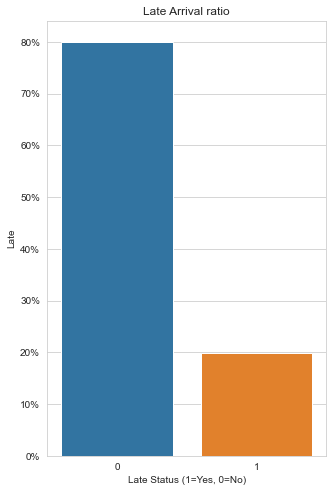

In [55]:
xLate, yLate = getCount(pandasDF["Late"])
myPlot(xLate, yLate, xLable="Late Status (1=Yes, 0=No)", yLable="% Percentage", title="Late Arrival ratio",figsize=(5,8),type='bar')

+ The above bar graph allows us to view the ratio of late flights to flights arrived on time

In [54]:
print("The Correlation between the DepDelay and ArrDelay is >>>> ", StatsFlightData.stat.corr("DepDelay","ArrDelay"))

The Correlation between the DepDelay and ArrDelay is >>>>  0.9394056759019349


+ Now Let us do a summary of the time series data

<AxesSubplot:xlabel='DayofMonth', ylabel='count'>

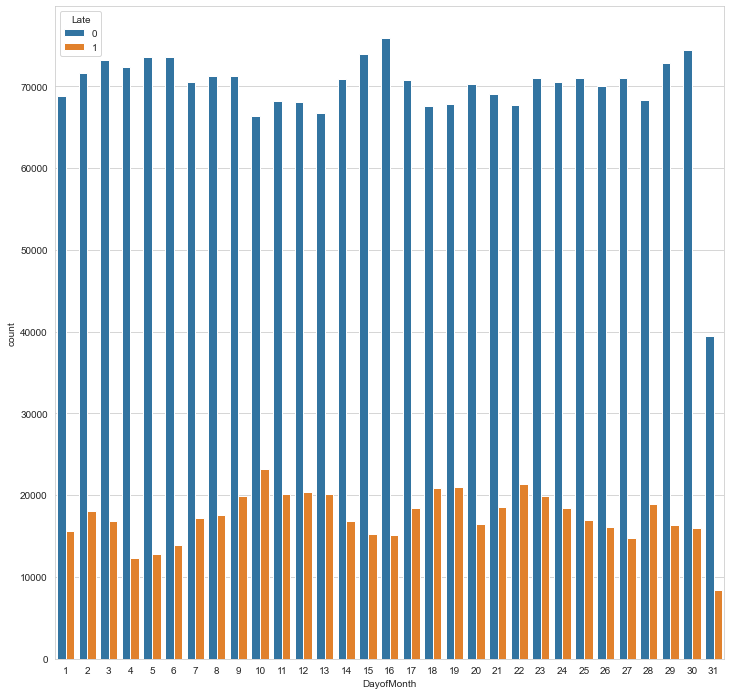

In [62]:
plt.subplots(figsize=(12,12))
sns.countplot(x='DayofMonth',hue='Late',data=pandasDF)

+ From this we understand that most flight become **delayed** in the middle of the month and very **less** delays occur at the end of the month

<AxesSubplot:xlabel='DayOfWeek', ylabel='count'>

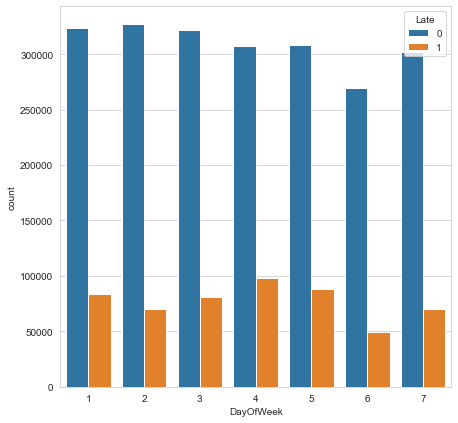

In [61]:
plt.subplots(figsize=(7,7))
sns.countplot(x='DayOfWeek',hue='Late',data=pandasDF)

+ Most Delays occur on the second day of the week

<AxesSubplot:xlabel='OriginAirportID', ylabel='count'>

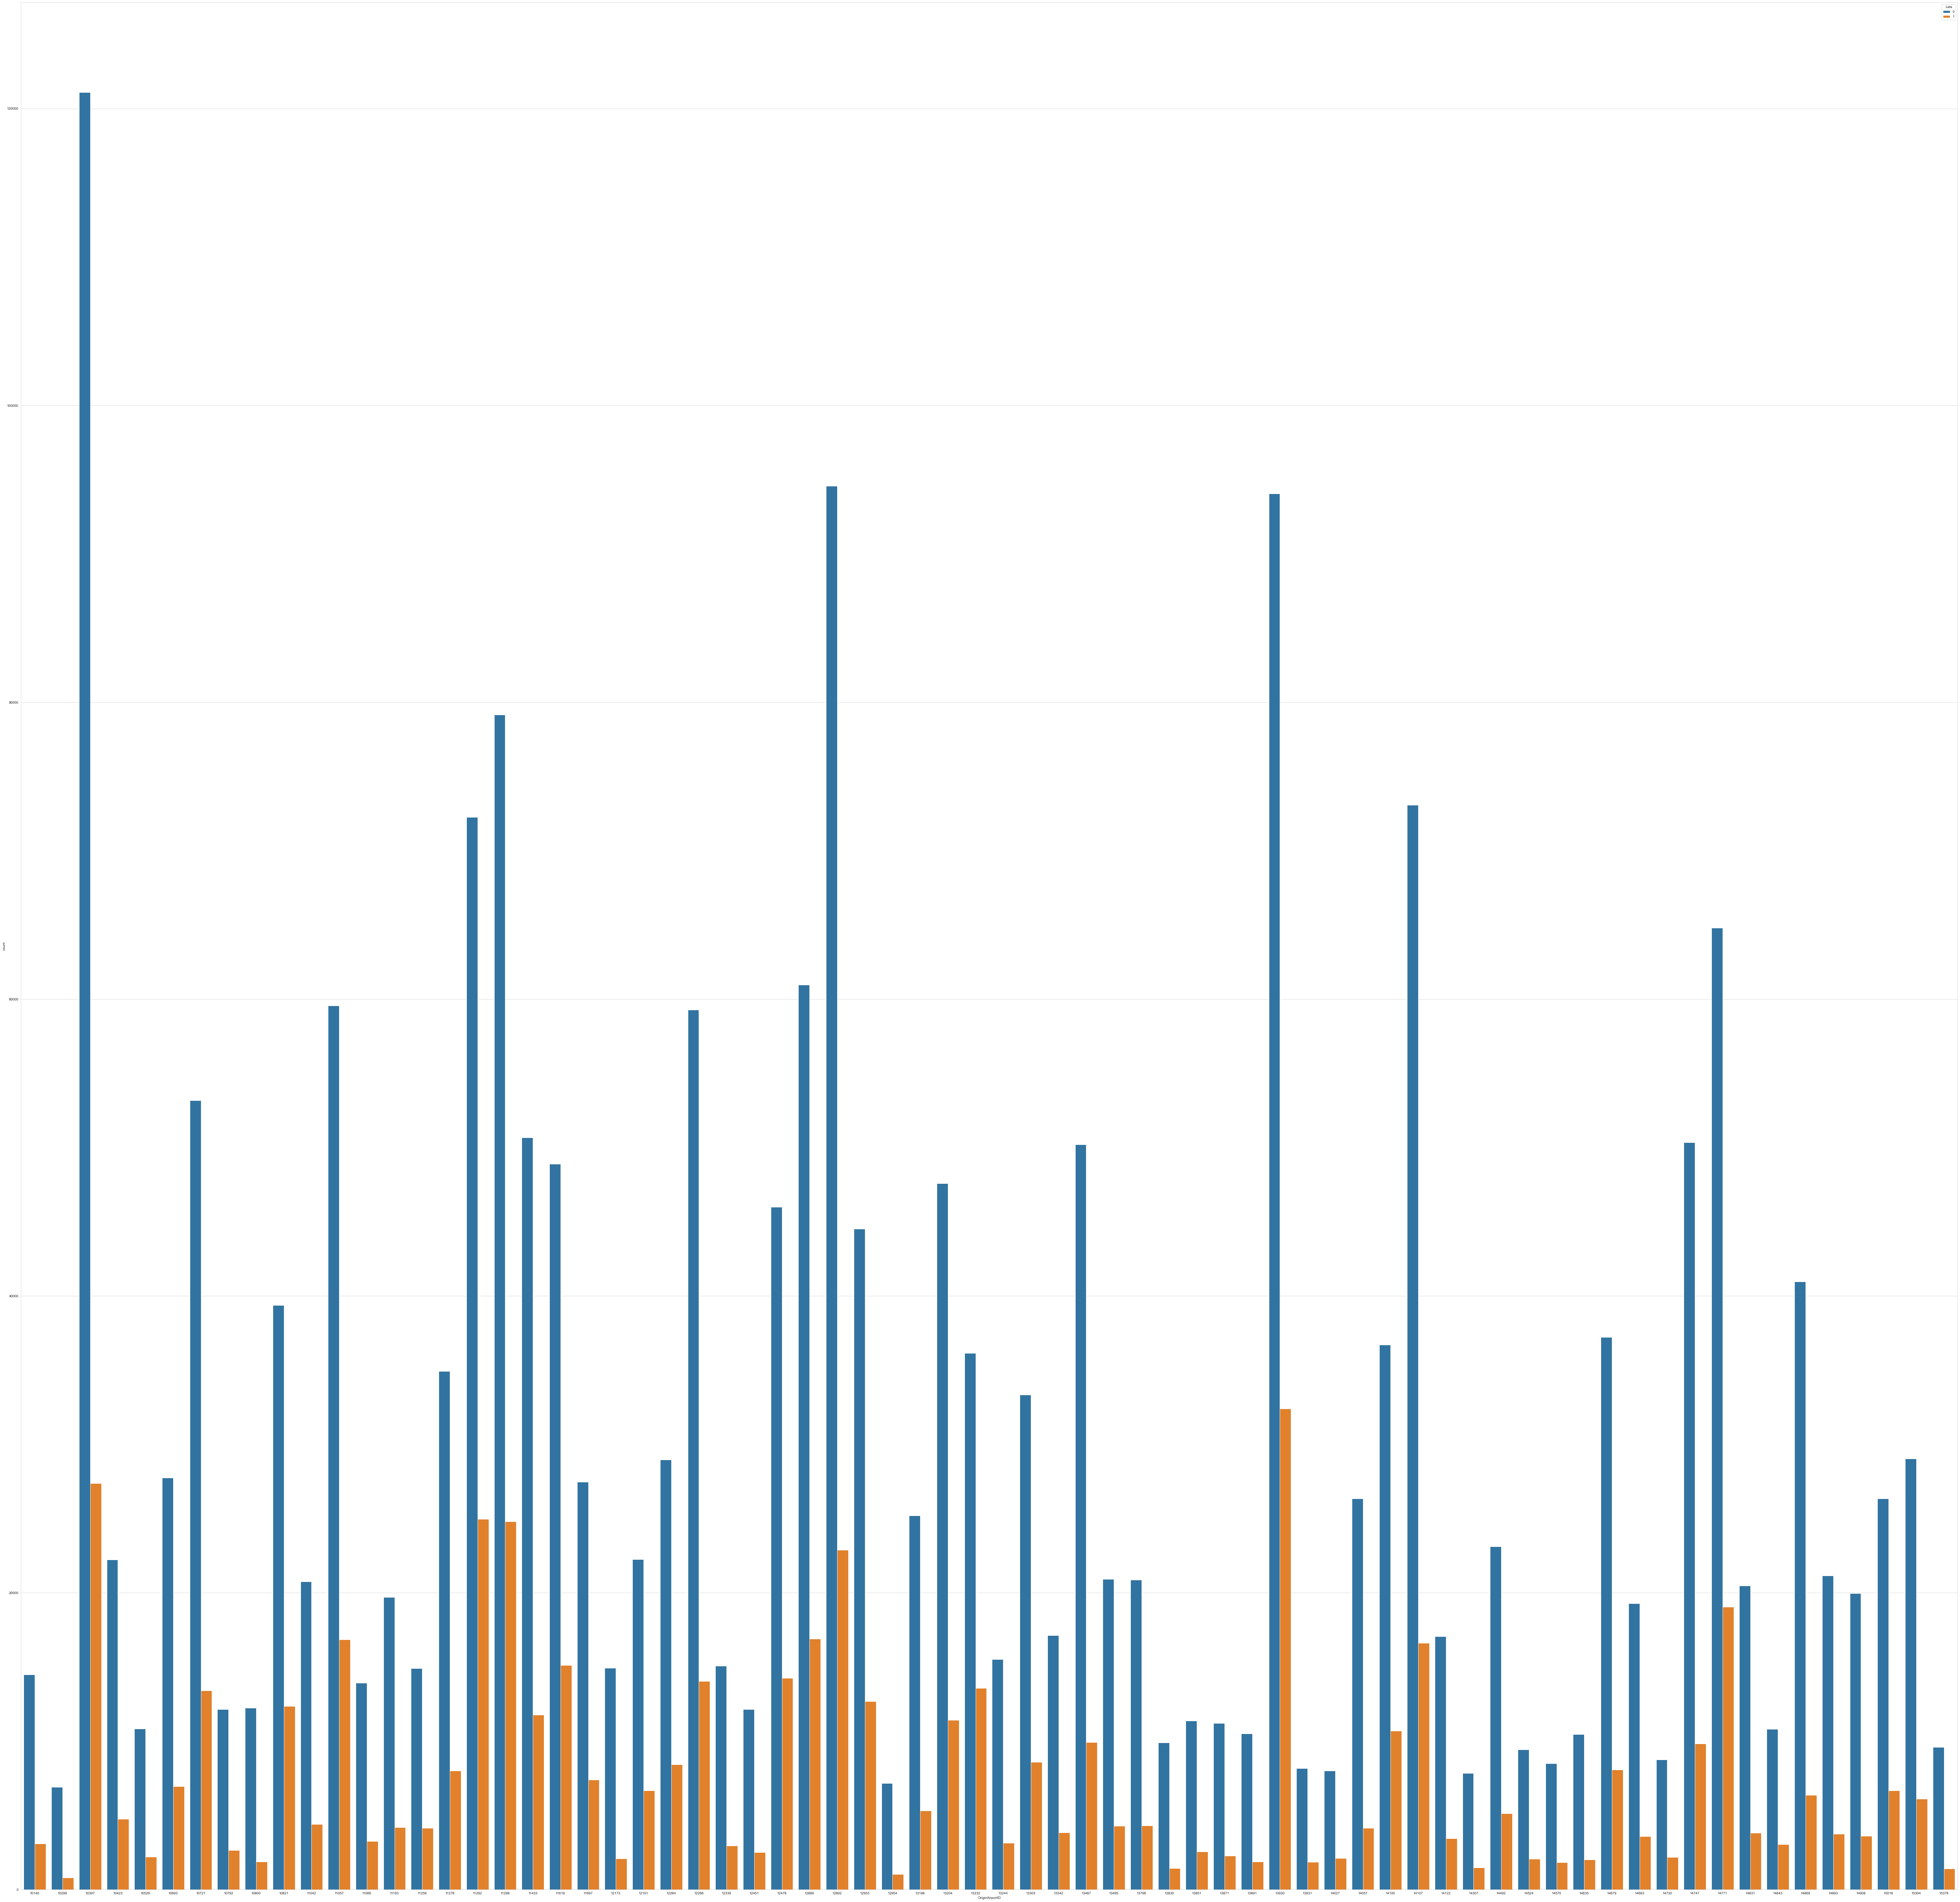

In [64]:
px.bar()